In [8]:
import math
import warnings
import psycopg2
warnings.filterwarnings('ignore')

%matplotlib inline
from IPython.display import Markdown
import datetime
from datetime import datetime, timedelta
from random import random
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from dotenv import load_dotenv
import requests
import json
from matplotlib.dates import DateFormatter

load_dotenv()
# create/get walkdata
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta
# Load the parameters
with open('arguments.json', 'r') as fid:
    arguments = json.load(fid)
    
display(Markdown(f'''
# Besucher\\*innenzahlen-Bericht: {arguments["start_month"]} {arguments["start_year"]}

Dies ist der aktuelle Besucher\\*innenzahlen-Bericht. Die Daten wurden von der Sensorbox **{arguments["name"]}** aufgenommen.

Adresse: {arguments["adresse"]}.
<br/><br/>'''))
year = 2023
month = 1
hour = 0
month_str = "Januar"
# Set time period
start_2023 = datetime(year=2023, month=1, day=1, hour=0)
start = datetime(year=year, month=month, day=1, hour=0)
end = datetime(year=year, month=month+1, day=1, hour=0) if month < 12 else datetime(year=year+1, month=1, day=1, hour=0) 
# download data
import db_service

# connect to database
con = db_service.connect()

# # try again in 5 minutes
# if isinstance(con, int):
#     logging.error(
#         "Could not connect to database. Trying again in 5 minutes")
#     time.sleep(30)
#     break
start_date = arguments["start_date"]
end_date = arguments["end_date"]
sensor_id = arguments["sensor_id"]
measurements_timerange = db_service.load_ds_measurements(con = con, sensor_id = sensor_id, start_time = start_date, end_time = end_date)


# Besucher\*innenzahlen-Bericht: 8 2024

Dies ist der aktuelle Besucher\*innenzahlen-Bericht. Die Daten wurden von der Sensorbox **Nobis** aufgenommen.

Adresse: Münsterplatz.
<br/><br/>


## Besucher\*innenzahlen und Sonnenstunden

In Diagramm sind die Besucher\*innenzahlen jedes Tages des Monats und die Sonnenstunden pro Tag als Balken dargestellt. So lässt sich ein Überblick über den Monat gewinnen und eine Korrelation zwischen Wetter und Besucher\*innenzahlen herstellen.  
Wochenenden sind in grün markiert.

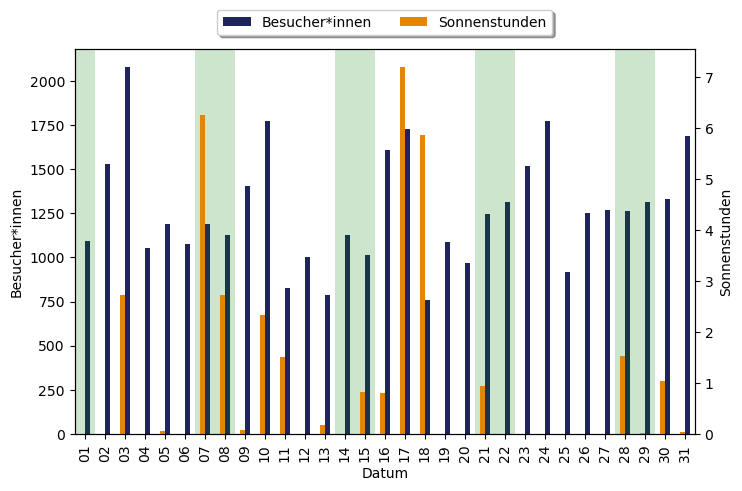

In [ ]:
# coordinates for Aachen
lat = arguments["latitude"]
lon = arguments["longitude"]

# configure data for plotting
df_walkdata_month = measurements_timerange.copy()
df_walkdata_month = df_walkdata_month[['timestamp', 'value']]
df_walkdata_month.rename(columns={"timestamp": "date", "value": "people"}, inplace = True)
df_walkdata_month_daily_sum = df_walkdata_month.resample('D', on='date').sum() # sum up people per day
df_walkdata_month_hourly_sum = df_walkdata_month.resample('H', on='date').sum() # sum up people per hour
## Get Sunshine data
# fetch sundata for chosen month
url = 'https://api.brightsky.dev/weather'
params = dict(date=start.isoformat(), last_date=end.isoformat(), lat=lat, lon=lon)
resp = requests.get(url=url, params=params)
sundata_month = resp.json()
df_sundata_month = pd.DataFrame(sundata_month['weather'])
df_sundata_month = df_sundata_month[["timestamp", "sunshine"]]
df_sundata_month.drop(df_sundata_month.tail(1).index, inplace=True) # drop last row
# convert formats and sum over days
df_sundata_month['timestamp'] = df_sundata_month['timestamp'].apply(lambda t: datetime.fromisoformat(t))
df_sundata_month = df_sundata_month.resample('D', on='timestamp').sum() # sum up sunshine hours per day
df_sundata_month['sunshine'] = df_sundata_month['sunshine'] / 60
df_sundata_month.reset_index(inplace=True)
# add monthly sun- & walk-dataframes together
if len(df_walkdata_month_daily_sum) == len(df_sundata_month):
    df_sundata_month['people'] = df_walkdata_month_daily_sum['people'].values
else:
    print("Length mismatch")
# Plot 1:
# shift time to noon for better weekend highlighting
df_sundata_month.timestamp = df_sundata_month.timestamp + timedelta(hours=12)

# Plot line chart
sundata_for_plot = df_sundata_month.copy()
sundata_for_plot.set_index("timestamp", inplace=True)
plot1 = sundata_for_plot.plot(kind= 'bar', secondary_y= 'sunshine', figsize=(8, 5), rot=90, color=["#e38606", "#1f2459"])

# highlight weekends
for i in range(len(sundata_for_plot)):
   if sundata_for_plot.index[i].weekday()==5 or sundata_for_plot.index[i].weekday()==6:
       plot1.axvspan(xmin=i-0.5, xmax=i+0.5, facecolor='green', edgecolor='none', alpha=.2)

# text
display(Markdown(f'''
## Besucher\\*innenzahlen und Sonnenstunden

In Diagramm sind die Besucher\\*innenzahlen jedes Tages des Monats und die Sonnenstunden pro Tag als Balken dargestellt. So lässt sich ein Überblick über den Monat gewinnen und eine Korrelation zwischen Wetter und Besucher\\*innenzahlen herstellen.  
Wochenenden sind in grün markiert.'''))

# create legend
h1, l1 = plot1.get_legend_handles_labels()
h2, l2 = plot1.right_ax.get_legend_handles_labels()
handles = h1+h2
labels = ["Besucher*innen", "Sonnenstunden"]  # without translation: l1+l2
plot1.legend(handles, labels, bbox_to_anchor=(0.5, 1.12), loc="upper center",  fancybox=True, shadow=True, ncol=2)

# set and translate labels
plot1.set_ylabel('Besucher*innen')
plot1.right_ax.set_ylabel('Sonnenstunden')
plot1.set_xlabel('Datum')

# format x-ticks
plot1.xaxis.set_major_formatter(DateFormatter('%d')) # ax.xaxis.set_major_locator(HourLocator(interval=2)) # tick every two hours

plt.show()

<div style="page-break-after: always;"></div>


## Sonnenstunden gegen Besucher\*innenzahlen für den Monat

Hier werden die Sonnenstunden gegen Besucher\*innenzahlen für den Monat aufgetragen. So lässt sich der Zusammenhang zwischen viel Sonne und wenig Sonne und den Besucher\*innenzahlen erkennen.

Grau markierte Bereiche bedeuten, dass keine Tage dieses Monats mit diesem Sonnenstunden-Intervall existieren.

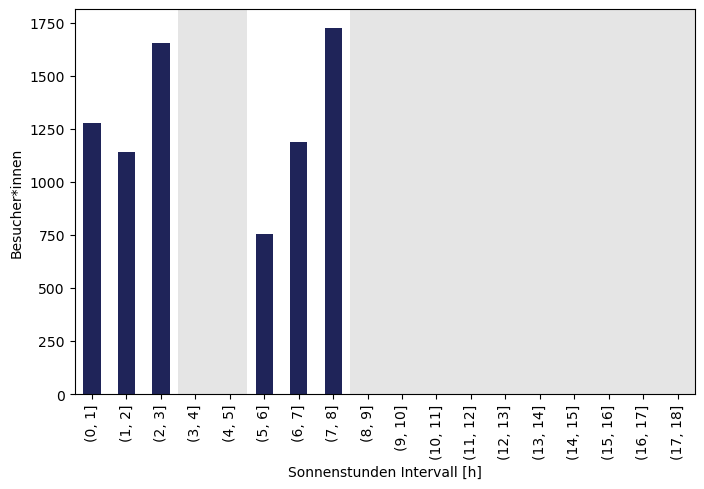

In [ ]:

# Plot 2:
sundata_mean = df_sundata_month[["sunshine", "people"]].copy()
sundata_mean["daycount"] = 1
sundata_sum = sundata_mean.groupby(pd.cut(sundata_mean['sunshine'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])).sum()
sundata_mean = sundata_mean.groupby(pd.cut(sundata_mean['sunshine'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])).mean()
sundata_mean["days"] = sundata_sum["daycount"] # todo: evtl noch bars mit anzahl der tage innerhalb der ranges hinzufügen
sundata_mean.index.names = ['sunshine_range']
sundata_mean.reset_index(inplace=True)
plot2 = sundata_mean.plot.bar(x='sunshine_range', y='people', figsize=(8, 5), rot=90, color=["#1f2459"], legend=False)

# mark non-existing hour-ranges 
for i in range(len(sundata_mean)):
    if math.isnan(sundata_mean["sunshine"][i]):
        plot2.axvspan(xmin=i - 0.5, xmax=i + 0.5, facecolor='grey', edgecolor='none', alpha=.2)

# text
display(Markdown(f'''<div style="page-break-after: always;"></div>'''))
display(Markdown(f'''
## Sonnenstunden gegen Besucher\\*innenzahlen für den Monat

Hier werden die Sonnenstunden gegen Besucher\\*innenzahlen für den Monat aufgetragen. So lässt sich der Zusammenhang zwischen viel Sonne und wenig Sonne und den Besucher\\*innenzahlen erkennen.

Grau markierte Bereiche bedeuten, dass keine Tage dieses Monats mit diesem Sonnenstunden-Intervall existieren.'''))

# set labels
plot2.set_ylabel('Besucher*innen')
plot2.set_xlabel('Sonnenstunden Intervall [h]')

plt.show()

<div style="page-break-after: always;"></div>


## Durchschnittliche Besucher*innenzahlen je Wochentag

Das Diagramm zeigt die durchschnittlichen Besucher\*innenzahlen an den einzelnen Wochentagen im Monat Januar. So können besonders akttraktive Tage mit vielen Besucher\*innen ermittelt werden.

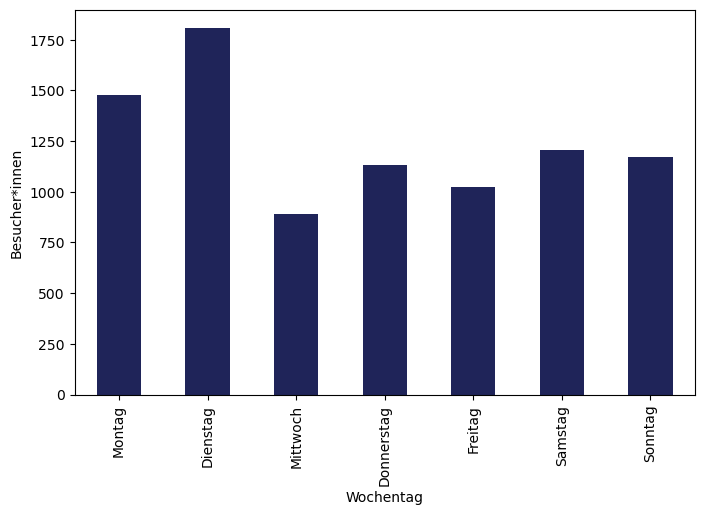

In [11]:

# Plot 3:
sundata_by_weekday = df_sundata_month.copy()
sundata_by_weekday["weekday"] = sundata_by_weekday["timestamp"].apply(lambda t: t.weekday())
sundata_by_weekday["weekday_str"] = sundata_by_weekday["weekday"].apply(lambda d: ["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Freitag", "Samstag", "Sonntag"][d])
sundata_by_weekday = sundata_by_weekday.groupby(['weekday_str']).mean()
sundata_by_weekday.sort_values("weekday", inplace=True)
plot3 = sundata_by_weekday.plot.bar(y='people', figsize=(8, 5), rot=90, color=["#1f2459"], legend=False)

# text
display(Markdown(f'''<div style="page-break-after: always;"></div>'''))
display(Markdown(f'''
## Durchschnittliche Besucher*innenzahlen je Wochentag

Das Diagramm zeigt die durchschnittlichen Besucher\\*innenzahlen an den einzelnen Wochentagen im Monat {month_str}. So können besonders akttraktive Tage mit vielen Besucher\\*innen ermittelt werden.'''))

# set labels
plot3.set_ylabel('Besucher*innen')
plot3.set_xlabel('Wochentag')

plt.show()

<div style="page-break-after: always;"></div>


## Besucher*innenfrequenz nach Tageszeit

Es werden die durchschnittlichen Besucher\*innenzahlen nach Tageszeit dargestellt. So lässt sich erkennen, in welchem Zeitfenster eine Ladenöffnung das größte Potential hat.

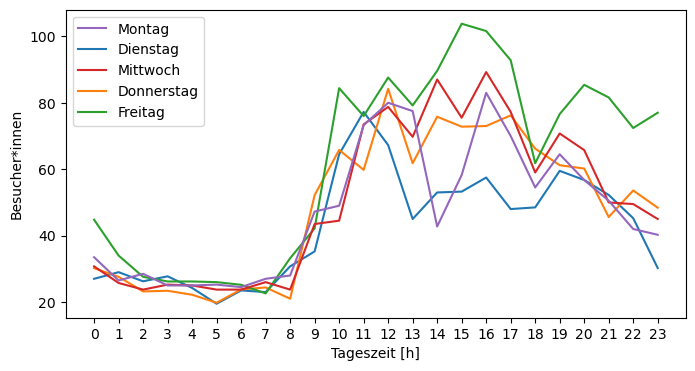

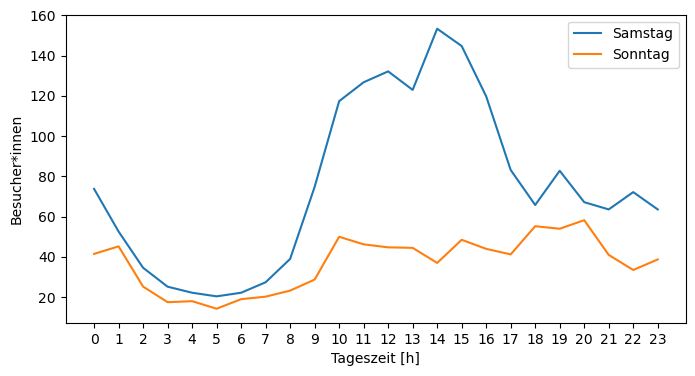

In [12]:

# Plot 4:
# Ergibt vermutlich mehr Sinn mit Daten von mehr als einem Monat
hourly_visitors = df_walkdata_month_hourly_sum.reset_index()
hourly_visitors["hour"] = hourly_visitors["date"].apply(lambda t: t.hour)
hourly_visitors["dayofweek"] = hourly_visitors["date"].dt.day_name(locale="de_DE.utf-8")
hourly_visitors = hourly_visitors.groupby(['hour', 'dayofweek'], as_index=False).mean(numeric_only=True)
fig, plot41 = plt.subplots(figsize=(8, 4))
for day, group in hourly_visitors.groupby('dayofweek'):
    if day in ["Samstag", "Sonntag"]:
        continue
    else:
        plot41.plot(group["hour"], group["people"], label=day)

# text
display(Markdown(f'''<div style="page-break-after: always;"></div>'''))
display(Markdown(f'''
## Besucher*innenfrequenz nach Tageszeit

Es werden die durchschnittlichen Besucher\\*innenzahlen nach Tageszeit dargestellt. So lässt sich erkennen, in welchem Zeitfenster eine Ladenöffnung das größte Potential hat.'''))

# set labels
plot41.set_ylabel('Besucher*innen')
plot41.set_xlabel('Tageszeit [h]')
plot41.set_xticks(hourly_visitors['hour'].unique())
plot41.legend()

handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,3,1,2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.show()

# plot for saturdays and sundays
fig, plot42 = plt.subplots(figsize=(8, 4))
for day, group in hourly_visitors.groupby('dayofweek'):
    if day not in ["Samstag", "Sonntag"]:
        continue
    else:
        plot42.plot(group["hour"], group["people"], label=day)

# set labels
plot42.set_ylabel('Besucher*innen')
plot42.set_xlabel('Tageszeit [h]')
plot42.set_xticks(hourly_visitors['hour'].unique())
plot42.legend()

plt.show()

In [13]:

## get data for full plots:
start_full = "2020-01-01"
walkdata_full = db_service.load_ds_measurements(con, sensor_id, start_full, end_date)
walkdata_full = walkdata_full[['timestamp', 'value']]
walkdata_full.rename(columns={"timestamp": "date", "value": "people"}, inplace = True)

# sum up people per date
walkdata_full_sum = walkdata_full.resample('D', on='date').sum()

real_start_date = walkdata_full_sum.index[0]

# fetch sundata for all months
params = dict(date=real_start_date.isoformat(), last_date=end_date, lat=lat, lon=lon)
resp = requests.get(url=url, params=params)
sundata_full = resp.json()

# format sundata
df_sundata_full_hourly_sum = pd.DataFrame(sundata_full['weather'])  # sum over hours not needed (comes like this from api)
df_sundata_full_hourly_sum = df_sundata_full_hourly_sum[["timestamp", "sunshine"]]
df_sundata_full_hourly_sum.drop(df_sundata_full_hourly_sum.tail(1).index, inplace=True) # drop last row
df_sundata_full_hourly_sum['timestamp'] = df_sundata_full_hourly_sum['timestamp'].apply(lambda t: datetime.fromisoformat(t))
df_sundata_full_hourly_sum['sunshine'] = df_sundata_full_hourly_sum['sunshine'] / 60

# sum up sunshine hours per date
df_sundata_full_daily_sum = df_sundata_full_hourly_sum.resample('D', on='timestamp').sum()

# add full sun- & walk-dataframes together
if len(walkdata_full_sum) == len(df_sundata_full_daily_sum):
    df_sundata_full_daily_sum['people'] = walkdata_full_sum['people'].values
else:
    print("Length mismatch")

<div style="page-break-after: always;"></div>


## Sonnenstunden gegen Besucher\*innenzahlen seit Beginn der Aufzeichnung April 2023

Hier werden die Sonnenstunden gegen Besucher\*innenzahlen seit Beginn der Aufzeichnung aufgetragen. So lässt sich der Zusammenhang zwischen viel Sonne und wenig Sonne und den Besucher\*innenzahlen erkennen.

Grau markierte Bereiche bedeuten, dass keine Tage in den Aufzeichnungen mit diesem Sonnenstunden-Intervall existieren.

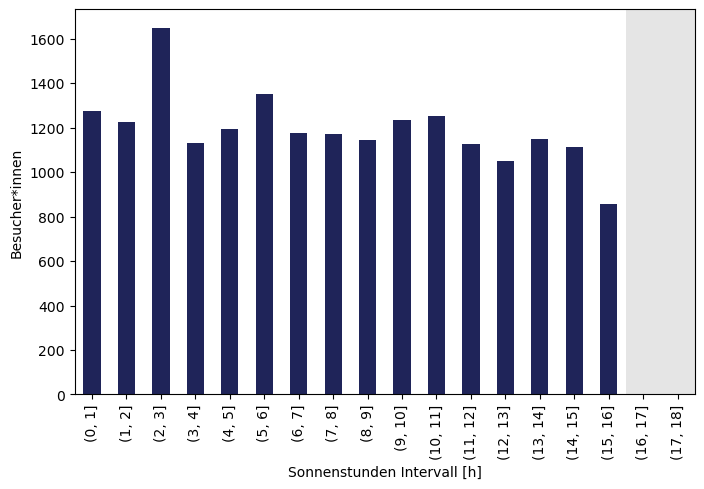

In [14]:
# Plot 5:
sundata_grouped = df_sundata_full_daily_sum[["sunshine", "people"]].copy()
sundata_grouped = sundata_grouped.groupby(pd.cut(sundata_grouped['sunshine'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])).mean()
sundata_grouped.index.names = ['sunshine_range']
sundata_grouped.reset_index(inplace=True)
plot5 = sundata_grouped.plot.bar(x='sunshine_range', y='people', figsize=(8, 5), rot=90, color=["#1f2459"], legend=False)

# mark non-existing hour-ranges 
for i in range(len(sundata_grouped)):
    if math.isnan(sundata_grouped["sunshine"][i]):
        plot5.axvspan(xmin=i - 0.5, xmax=i + 0.5, facecolor='grey', edgecolor='none', alpha=.2)

# text
display(Markdown(f'''<div style="page-break-after: always;"></div>'''))
display(Markdown(f'''
## Sonnenstunden gegen Besucher\\*innenzahlen seit Beginn der Aufzeichnung April 2023

Hier werden die Sonnenstunden gegen Besucher\\*innenzahlen seit Beginn der Aufzeichnung aufgetragen. So lässt sich der Zusammenhang zwischen viel Sonne und wenig Sonne und den Besucher\\*innenzahlen erkennen.

Grau markierte Bereiche bedeuten, dass keine Tage in den Aufzeichnungen mit diesem Sonnenstunden-Intervall existieren.'''))

# set labels
plot5.set_ylabel('Besucher*innen')
plot5.set_xlabel('Sonnenstunden Intervall [h]')

plt.show()

<div style="page-break-after: always;"></div>


## Wochentage gegen Besucher\*innenzahlen seit Beginn der Aufzeichnung April 2023

Hier werden die Wochentage gegen Besucher\*innenzahlen seit Beginn der Aufzeichnung aufgetragen. So können besonders akttraktive Tage mit vielen Besucher\*innen ermittelt werden.

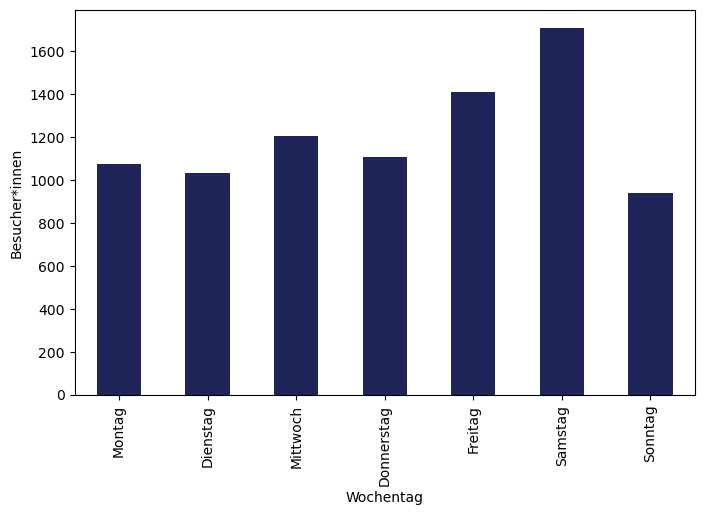

In [15]:

# Plot 6:
walkdata_by_day = walkdata_full_sum.copy()
walkdata_by_day.reset_index(inplace=True)
walkdata_by_day["weekday"] = walkdata_by_day["date"].apply(lambda t: t.weekday())
walkdata_by_day["weekday_str"] = walkdata_by_day["weekday"].apply(lambda d: ["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Freitag", "Samstag", "Sonntag"][d])
walkdata_by_day = walkdata_by_day.groupby(['weekday_str']).mean()
walkdata_by_day.sort_values("weekday", inplace=True)
plot6 = walkdata_by_day.plot.bar(y='people', figsize=(8, 5), rot=90, color=["#1f2459"], legend=False)

# text
display(Markdown(f'''<div style="page-break-after: always;"></div>'''))
display(Markdown(f'''
## Wochentage gegen Besucher\\*innenzahlen seit Beginn der Aufzeichnung April 2023

Hier werden die Wochentage gegen Besucher\\*innenzahlen seit Beginn der Aufzeichnung aufgetragen. So können besonders akttraktive Tage mit vielen Besucher\\*innen ermittelt werden.'''))

# set labels
plot6.set_ylabel('Besucher*innen')
plot6.set_xlabel('Wochentag')

plt.show()

<div style="page-break-after: always;"></div>


## Stunden gegen Besucher\*innenzahlen seit Beginn der Aufzeichnung April 2023

Hier werden die Stunden gegen die Besucher\*innenzahlen seit Beginn der Aufzeichnung aufgetragen. So lässt sich erkennen, in welchem Zeitfenster eine Ladenöffnung das größte Potential hat.

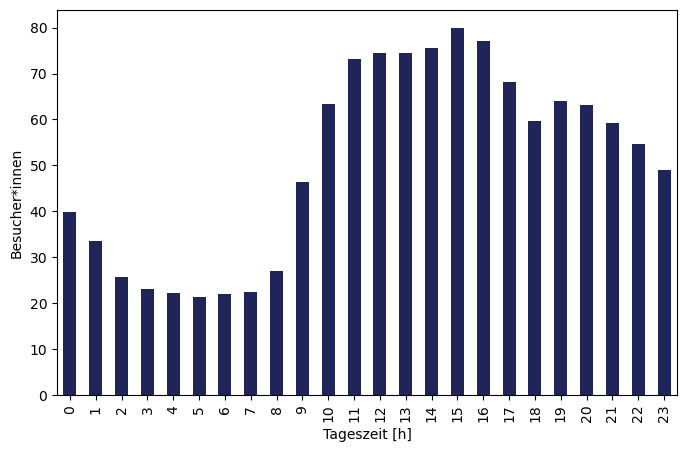

In [16]:

# Plot 7:
df_walkdata_full_hourly_sum = walkdata_full.resample('H', on='date').sum() # sum up people per hour
hourly_visitors = df_walkdata_full_hourly_sum.reset_index()
hourly_visitors["hour"] = hourly_visitors["date"].apply(lambda t: t.hour)
hourly_visitors = hourly_visitors.groupby(['hour']).mean()
ax7 = hourly_visitors.plot.bar(y='people', figsize=(8, 5), rot=90, color=["#1f2459"], legend=False)

# text
display(Markdown(f'''<div style="page-break-after: always;"></div>'''))
display(Markdown(f'''
## Stunden gegen Besucher\\*innenzahlen seit Beginn der Aufzeichnung April 2023

Hier werden die Stunden gegen die Besucher\\*innenzahlen seit Beginn der Aufzeichnung aufgetragen. So lässt sich erkennen, in welchem Zeitfenster eine Ladenöffnung das größte Potential hat.'''))

# set labels
ax7.set_ylabel('Besucher*innen')
ax7.set_xlabel('Tageszeit [h]')

plt.show()

<div style="page-break-after: always;"></div>


## Besucher*innenzahlen seit Beginn der Aufzeichnung

Hier werden die Besucher\*innenzahlen seit Beginn der Aufzeichnung dargestellt. So lässt sich die Entwicklung der Besucher*innen im Laufe der Zeit erkennen.

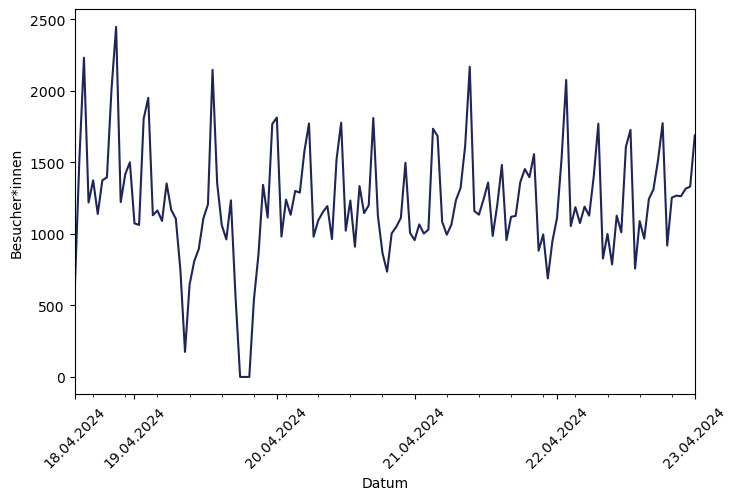

In [17]:
# Plot 8:
ax8 = walkdata_full_sum.plot.line(y="people", figsize=(8, 5), legend=False, color=["#1f2459"])

# text
display(Markdown(f'''<div style="page-break-after: always;"></div>'''))
display(Markdown(f'''
## Besucher*innenzahlen seit Beginn der Aufzeichnung

Hier werden die Besucher\\*innenzahlen seit Beginn der Aufzeichnung dargestellt. So lässt sich die Entwicklung der Besucher*innen im Laufe der Zeit erkennen.'''))

ax8.set_ylabel("Besucher*innen")
ax8.set_xlabel("Datum")
ax8.set_xticklabels(walkdata_full_sum.index.strftime("%d.%m.%Y").unique(), rotation=45)

plt.show()